# Medical Data Visualizer

This notebook demonstrates step by step how the data from **`medical_examination.csv`** is processed and visualized. The goal is to explore the relationships between cardiovascular disease and different health/lifestyle factors using **pandas**, **matplotlib** and **seaborn**.

We will:
- Import and inspect the dataset
- Prepare and normalize the data (BMI, cholesterol, glucose, etc.)
- Create categorical plots to compare risk factors
- Generate a heatmap to show correlations between measurements

In [1]:
import medical_data_visualizer as mdv
mdv.df.head()

,id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,overweight
0,0,18393,2,168,62.0,110,80,0,0,0,0,1,0,0
1,1,20228,1,156,85.0,140,90,1,0,0,0,1,1,1
2,2,18857,1,165,64.0,130,70,1,0,0,0,0,1,0
3,3,17623,2,169,82.0,150,100,0,0,0,0,1,1,1
4,4,17474,1,156,56.0,100,60,0,0,0,0,0,0,0


## Overweight indicator

In [2]:
# Sanity check: overweight column should exist and contain only 0/1
mdv.df["overweight"].value_counts(dropna=False)

1    43546
0    26454
Name: overweight, dtype: int64

In [3]:
# Spot-check BMI calculations vs overweight flag
tmp = mdv.df.assign(
    height_m = mdv.df.height / 100,
    bmi = mdv.df.weight / ( (mdv.df.height/100) ** 2 )
)[["height", "weight", "bmi", "overweight"]]

tmp.head(10)

,height,weight,bmi,overweight
0,168,62.0,21.967120,0
1,156,85.0,34.927679,1
2,165,64.0,23.507805,0
3,169,82.0,28.710479,1
4,156,56.0,23.011177,0
5,151,67.0,29.384676,1
6,157,93.0,37.729725,1
7,178,95.0,29.983588,1
8,158,71.0,28.440955,1
9,164,68.0,25.282570,1


In [4]:
# Quick statistical summary of BMI and overweight
mdv.df.assign(
    bmi = mdv.df.weight / ( (mdv.df.height/100) ** 2 )
)[["height", "weight", "bmi", "overweight"]].describe(include="all")

,height,weight,bmi,overweight
count,70000.000000,70000.000000,70000.000000,70000.000000
mean,164.359229,74.205690,27.556513,0.622086
std,8.210126,14.395757,6.091511,0.484870
min,55.000000,10.000000,3.471784,0.000000
25%,159.000000,65.000000,23.875115,0.000000
50%,165.000000,72.000000,26.374068,1.000000
75%,170.000000,82.000000,30.222222,1.000000
max,250.000000,200.000000,298.666667,1.000000


## Normalize cholesterol and gluc

In [5]:
# Quick schema + dtype checks
mdv.df[["cholesterol","gluc","overweight"]].dtypes

cholesterol    int32
gluc           int32
overweight     int32
dtype: object

In [6]:
# Domain checks (0/1 only)
mdv.df[["cholesterol","gluc"]].agg(["min","max","nunique"])

,cholesterol,gluc
min,0,0
max,1,1
nunique,2,2


In [7]:
# Distribution sanity
mdv.df["cholesterol"].value_counts(normalize=True).sort_index(), \
mdv.df["gluc"].value_counts(normalize=True).sort_index()

(0    0.748357
 1    0.251643
 Name: cholesterol, dtype: float64,
 0    0.8497
 1    0.1503
 Name: gluc, dtype: float64)

In [8]:
# Spot-check mapping against raw values
import pandas as pd
raw = pd.read_csv("medical_examination.csv")[["cholesterol","gluc"]].rename(columns={"cholesterol":"chol_raw","gluc":"gluc_raw"})
check = mdv.df[["cholesterol","gluc"]].rename(columns={"cholesterol":"chol_norm","gluc":"gluc_norm"}).join(raw)
check.assign(
    chol_expected = (check["chol_raw"] > 1).astype(int),
    gluc_expected = (check["gluc_raw"] > 1).astype(int),
).head(10)

,chol_norm,gluc_norm,chol_raw,gluc_raw,chol_expected,gluc_expected
0,0,0,1,1,0,0
1,1,0,3,1,1,0
2,1,0,3,1,1,0
3,0,0,1,1,0,0
4,0,0,1,1,0,0
5,1,1,2,2,1,1
6,1,0,3,1,1,0
7,1,1,3,3,1,1
8,0,0,1,1,0,0
9,0,0,1,1,0,0


## Categorical Plot

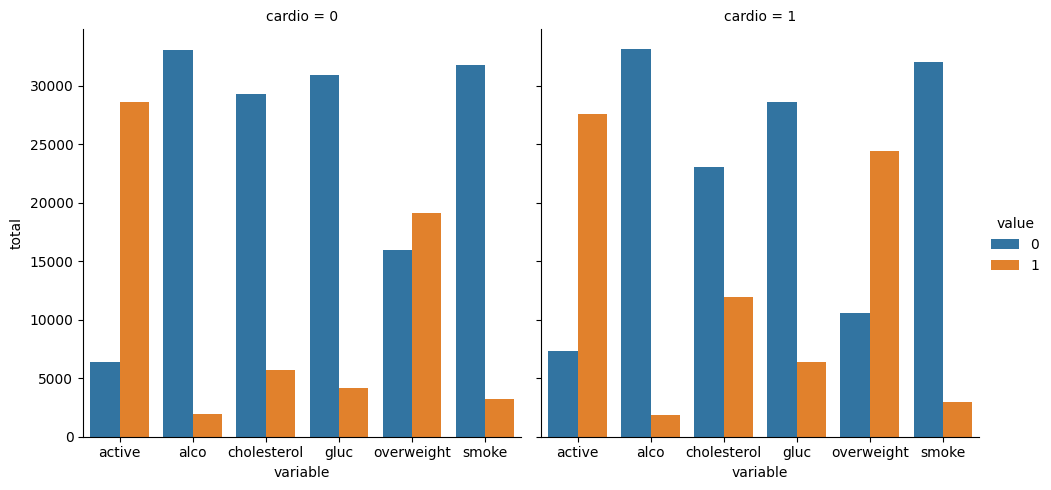

In [9]:
# Call draw_cat_plot and show the figure
from IPython.display import display
import matplotlib.pyplot as plt

fig = mdv.draw_cat_plot()
display(fig)
plt.close(fig)

In [10]:
# Inspect axes labels
ax = fig.axes[0]
ax.get_xlabel(), ax.get_ylabel()

# Inspect x-axis tick labels (should match expected order)
[label.get_text() for label in ax.get_xticklabels()]

# Count number of bars drawn
import matplotlib as mpl
len([rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)])

13

## Heat Map

In [11]:
import pandas as pd, numpy as np, importlib, medical_data_visualizer as mdv
mdv = importlib.reload(mdv)

# Recompute cleaning inline for inspection (mirrors mdv.draw_heat_map)
df_heat = mdv.df[mdv.df["ap_lo"] <= mdv.df["ap_hi"]].copy()
h_low, h_high = df_heat["height"].quantile([0.025, 0.975])
w_low, w_high = df_heat["weight"].quantile([0.025, 0.975])
df_heat = df_heat[
    df_heat["height"].between(h_low, h_high) & df_heat["weight"].between(w_low, w_high)
].copy()

df_shape_before = mdv.df.shape
df_shape_after  = df_heat.shape
bad_bp          = (~(df_heat["ap_lo"] <= df_heat["ap_hi"])).sum()
(df_shape_before, df_shape_after, bad_bp, (h_low, h_high), (w_low, w_high))

((70000, 14), (63126, 14), 0, (150.0, 180.0), (51.0, 107.0))

In [12]:
# Corr & mask
corr = df_heat.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
corr.shape, mask.shape, mask.dtype, int(mask.sum())

((14, 14), (14, 14), dtype('bool'), 105)

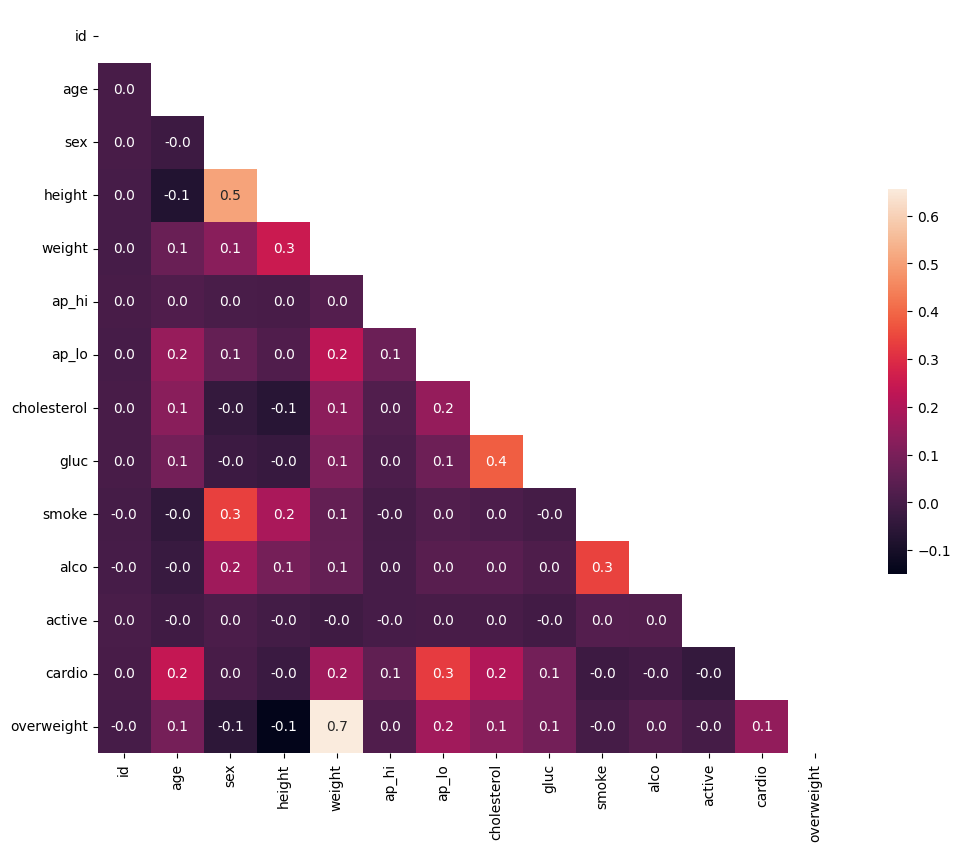

In [13]:
# Render once
from IPython.display import display
import matplotlib.pyplot as plt

fig = mdv.draw_heat_map()
display(fig)
plt.close(fig)

In [14]:
# Label & annotation sanity
ax = fig.axes[0]
xticks = [t.get_text() for t in ax.get_xticklabels()]
yticks = [t.get_text() for t in ax.get_yticklabels()]
has_text = any(hasattr(artist, "get_text") and artist.get_text() for artist in ax.get_children())

xticks, yticks[:5], has_text

(['id',
  'age',
  'sex',
  'height',
  'weight',
  'ap_hi',
  'ap_lo',
  'cholesterol',
  'gluc',
  'smoke',
  'alco',
  'active',
  'cardio',
  'overweight'],
 ['id', 'age', 'sex', 'height', 'weight'],
 True)

In [15]:
# Check label matching FCC’s expected order
expected_labels = ['id','age','sex','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active','cardio','overweight']
xticks == expected_labels

True